# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso, LassoCV, RidgeClassifier, RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from transformers import pipeline
import pandas as pd
import tqdm
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

2025-12-14 18:54:13.172399: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-14 18:54:13.218358: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-14 18:54:14.235969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Embedding,Dropout
from tensorflow.keras.callbacks import EarlyStopping

# EDA

In [3]:
# Read in ecommerce data set and rename cols
ecom = pd.read_csv('ecommerceDataset.csv', header= None).rename(columns= {0:'Class', 1: 'Text'})

# Drop NA value (only 1)
ecom = ecom.drop(index = ecom[ecom['Text'].isna()].index)

# Drop Dupplicates
ecom = ecom.drop_duplicates()
ecom

,Class,Text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...
...,...,...
50402,Electronics,Micromax Bharat 5 Plus Zero impact on visual d...
50403,Electronics,Microsoft Lumia 550 8GB 4G Black Microsoft lum...
50407,Electronics,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ..."
50408,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...


In [7]:
(ecom['Class'].value_counts(normalize =True))

Class
Household                 0.379973
Books                     0.225020
Clothing & Accessories    0.204086
Electronics               0.190922
Name: proportion, dtype: float64

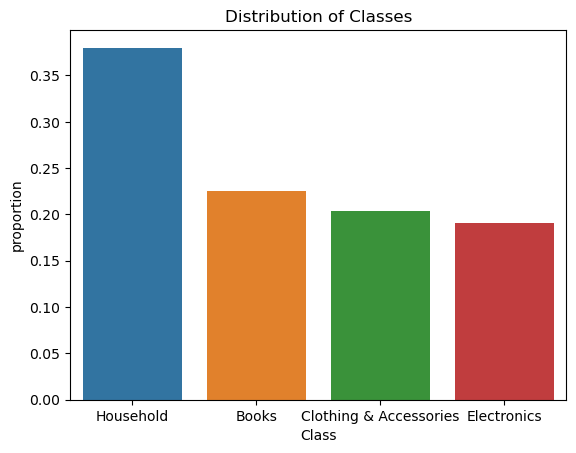

In [11]:
sns.barplot(ecom['Class'].value_counts(normalize =True).reset_index(), x = 'Class',y ='proportion', hue= 'Class').set_title("Distribution of Classes")
plt.show()

In [22]:
# Create a list to hold the results of each model
results = []

Defining and Splitting the Data

In [15]:
# Define x and y as text and intent in the data
x = ecom['Text']
y = ecom['Class']

# Split training data data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

tf-idf tokenizer

In [16]:
# Create tfidf tokenizer
tfidf = TfidfVectorizer(
    max_features= 1000,
    ngram_range= (1,2),
    stop_words= 'english'
)

# Train the tfidf vectorization on training data (takes 14.8seconds to run)
tfidf.fit(x_train)
# Transform the xtrain and xtest
x_train_tfidf = tfidf.transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

Word2vec embedding

# Traditional ML Models (baseline models)
- All these models used tf-idf vectorization embedding

## Logistic Regression

In [24]:
logistic = LogisticRegression()
logistic.fit(x_train_tfidf, y_train)

log_preds = logistic.predict(x_test_tfidf)

accuracy_score(y_test, log_preds)

0.926272253191872

In [23]:
log_preds = logistic.predict(x_test_tfidf)
log_acc = accuracy_score(y_test, log_preds)

results.append({
    "Model": "Logistic Regression (TF-IDF)",
    "Test Loss": np.nan,
    "Test Accuracy": log_acc
})

## SVM

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ----------------------------
# 1. Load and clean dataset
# ----------------------------

# Remove very rare / noisy classes (appear <= 5 times)

print("Dataset shape after cleaning:", ecom.shape)
print("\nClass counts:\n", ecom["Class"].value_counts())


# ----------------------------
# 4. TF-IDF vectorization
# ----------------------------
# ----------------------------
# 5. Train SVM model
# ----------------------------
svm_clf = LinearSVC(class_weight="balanced")   # handles any class imbalance
svm_clf.fit(x_train_tfidf, y_train)

# ----------------------------
# 6. Evaluate model
# ----------------------------
y_pred = svm_clf.predict(x_test_tfidf)

print("\nAccuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# ----------------------------
# 7. Helper: predict category for new text
# ----------------------------
def predict_category(text):
    vec = tfidf.transform([text])
    return svm_clf.predict(vec)[0]

# Example:
example_text = "Soft cotton scarf with floral pattern for women"
print("\nExample prediction:", predict_category(example_text))


Dataset shape after cleaning: (27802, 2)

Class counts:
 Class
Household                 10564
Books                      6256
Clothing & Accessories     5674
Electronics                5308
Name: count, dtype: int64

Accuracy: 0.9271713720553857

Classification Report:

                        precision    recall  f1-score   support

                 Books       0.93      0.93      0.93      1271
Clothing & Accessories       0.94      0.96      0.95      1121
           Electronics       0.90      0.91      0.90      1057
             Household       0.93      0.92      0.93      2112

              accuracy                           0.93      5561
             macro avg       0.93      0.93      0.93      5561
          weighted avg       0.93      0.93      0.93      5561


Confusion Matrix:

[[1177   13   33   48]
 [  11 1079   10   21]
 [  28    4  958   67]
 [  47   54   69 1942]]

Example prediction: Clothing & Accessories


# Deep Learning Models

## Text Tokenization and Preprocessing

Encode labels for y train and test

In [28]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

Tokenization and Token lengths

In [29]:
# Define keras tokenizer
keras_tokenizer = Tokenizer(num_words= 20000, oov_token= 'OOV')

# Fit tokenizer to training data
keras_tokenizer.fit_on_texts(x_train)

# Use keras tokenizer to implement tokenization on the 
x_train_seq = keras_tokenizer.texts_to_sequences(x_train)
x_test_seq = keras_tokenizer.texts_to_sequences(x_test)


lengths = [len(seq) for seq in keras_tokenizer.texts_to_sequences(x_train)]

np.percentile(lengths, [25, 50, 75, 90, 95, 99]) # It appears that the 95th percentile entry length is 320 words, so use 325 for max length in padding


array([ 35.,  77., 149., 251., 312., 611.])

In [30]:
len(keras_tokenizer.word_index)

81523

In [31]:
# Average number of tokens per entry
sum(lengths)/len(lengths)

114.6613911244998

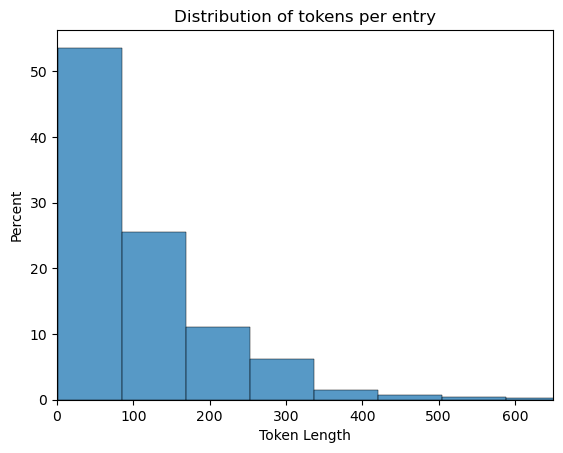

In [32]:
ax = sns.histplot(lengths, bins=100, stat='percent')
ax.set_xlim(0,650)
plt.title('Distribution of tokens per entry')
plt.xlabel('Token Length')
plt.show()

In [33]:
# Pad the training and test data (ensures inputs are all the same len)
max_len = 325
x_train_pad = pad_sequences(x_train_seq, maxlen = max_len, padding = 'pre', truncating= 'pre')
x_test_pad = pad_sequences(x_test_seq, maxlen= max_len, padding = 'pre', truncating= 'pre')

## Simple RNN Model

In [ ]:
# Dfine early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,          # stop after 2 epochs with no improvement
    restore_best_weights=True
)

### 3 Layer RNN

In [19]:
model = Sequential([
    Embedding(input_dim = 20000, output_dim= 64, 
              #input_length = max_len
              ),
    # RNN Block 1
    SimpleRNN(64, return_sequences = True),
    Dropout(0.3),
    
    # RNN Block 2
    SimpleRNN(64, return_sequences = True),
    Dropout(0.3),
    # RNN Block 3
    SimpleRNN(64),      
    Dropout(0.3),

    Dense(64),

    Dense(5, activation= 'softmax')])

# Complie the model together
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model.fit(x_train_pad, y_train_encoded, epochs=7, batch_size = 64, validation_split = 0.2, callbacks = [early_stop])

2025-12-13 00:06:27.859463: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


NameError: name 'x_train_pad' is not defined

In [55]:
rnn3_loss, rnn3_acc = model.evaluate(x_test_pad, y_test_encoded)

results.append({
    "Model": "SimpleRNN (3 layers)",
    "Test Loss": rnn3_loss,
    "Test Accuracy": rnn3_acc
})

174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9155 - loss: 0.3449


174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step


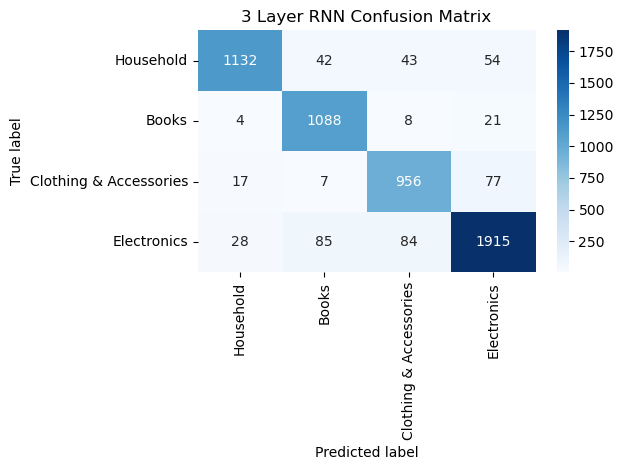

In [57]:
# 1. Predictions
y_pred_probs = model.predict(x_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# 3. Plot
# 
labels = ['Household', 'Books', 'Clothing & Accessories', 'Electronics']
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('3 Layer RNN Confusion Matrix')
plt.tight_layout()
plt.show()


## LSTM Models

### 2 Layer LSTM

In [60]:
model = Sequential([
    Embedding(input_dim = 20000, output_dim= 64, 
              #input_length = max_len
              ),
    LSTM(64, return_sequences = True),
    Dropout(0.3),

    LSTM(64),
    Dropout(0.3),

    Dense(5, activation= 'softmax')])

model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model.fit(x_train_pad, y_train_encoded, epochs=3, batch_size = 64)

Epoch 1/3
348/348 ━━━━━━━━━━━━━━━━━━━━ 63s 176ms/step - accuracy: 0.7753 - loss: 0.6338
Epoch 2/3
348/348 ━━━━━━━━━━━━━━━━━━━━ 64s 183ms/step - accuracy: 0.9411 - loss: 0.2468
Epoch 3/3
348/348 ━━━━━━━━━━━━━━━━━━━━ 66s 190ms/step - accuracy: 0.9500 - loss: 0.1950


In [64]:
lstm2_loss, lstm2_acc = model.evaluate(x_test_pad, y_test_encoded)

results.append({
    "Model": "LSTM (2 layers)",
    "Test Loss": lstm2_loss,
    "Test Accuracy": lstm2_acc
})

174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9468 - loss: 0.2054


174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


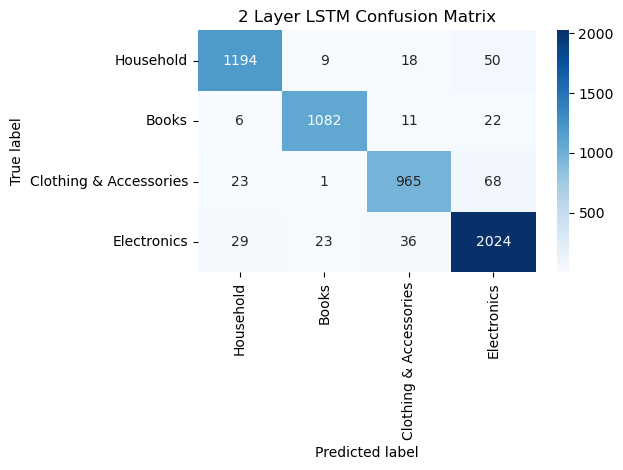

In [63]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Predictions
y_pred_probs = model.predict(x_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# 3. Plot
# 
labels = ['Household', 'Books', 'Clothing & Accessories', 'Electronics']
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('2 Layer LSTM Confusion Matrix')
plt.tight_layout()
plt.show()


# Evaluation of Models

In [65]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Test Accuracy", ascending=False).reset_index(drop=True)
results_df

,Model,Test Loss,Test Accuracy
0,LSTM (2 layers),0.205412,0.946772
1,LSTM (2 layers),0.205412,0.946772
2,LSTM (2 layers),0.236536,0.941018
3,"LSTM (2 layers, early stopping)",0.242219,0.937062
4,Logistic Regression (TF-IDF),NaN,0.926272
5,SimpleRNN (3 layers),0.344881,0.915483
6,SimpleRNN (3 layers),0.373492,0.911527


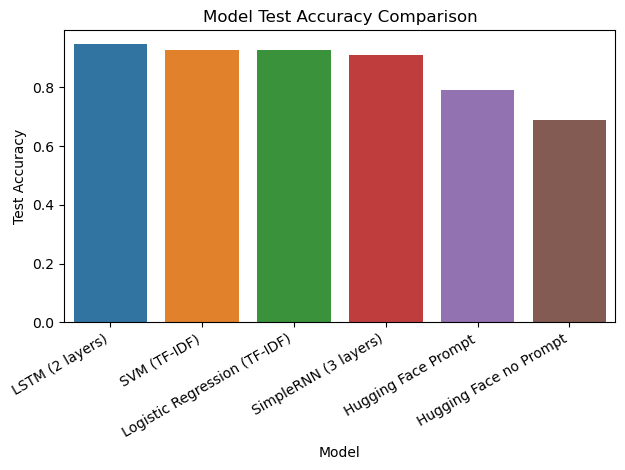

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame({
    "Model": [
        "LSTM (2 layers)",
        "SVM (TF-IDF)",
        "Logistic Regression (TF-IDF)",
        "SimpleRNN (3 layers)",
        "Hugging Face Prompt",
        "Hugging Face no Prompt"
    ],
    "Test Accuracy": [
        0.946772,
        0.927,
        0.926272,
        0.91152,
        0.79,
        0.69
    ]
})


plt.figure()
sns.barplot(data = results_df,x = "Model",y = "Test Accuracy", hue = 'Model')
plt.ylabel("Test Accuracy")
plt.title("Model Test Accuracy Comparison")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# Pretrained LLM/Transformer Models (from HuggingFace)

testing one one observation

In [38]:
# DF of our test data
test_llm = pd.DataFrame([x_test, y_test]).T

test_list = []

for i in tqdm.tqdm(test_llm['Text']):
    test_list.append(i)

100%|██████████| 5561/5561 [00:00<00:00, 3204798.65it/s]


In [179]:
classifier = pipeline("zero-shot-classification",
model = "facebook/bart-large-mnli",
device= 0) # most Downloaded 

Device set to use cpu


In [ ]:
# 1. Build a clean test DataFrame and reset the index so integer indices 0..n-1 are available
test_llm = pd.DataFrame({
    "Text": x_test,
    "Class": y_test
}).reset_index(drop=True)

# Optional sanity checks
print(test_llm.head())

# 2. Build a simple list of texts
test_list = test_llm["Text"].astype(str).tolist()

# 3. Zero-shot classifier (CPU)
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",     # consider a smaller model for speed
    device=-1                             # CPU (use 0 ONLY if you have a CUDA GPU)
)

candidate_labels = [
    'Household',
    'Books',
    'Clothing & Accessories',
    'Electronics'
]

# 4. Batched predictions, keeping original + predicted labels
my_dict = {}
batch_size = 64
n = len(test_list)        # use all of them, or set n = 500 for a subset

for start in tqdm.tqdm(range(0, n, batch_size)):
    batch = test_list[start:start + batch_size]

    preds = classifier(
        batch,
        candidate_labels=candidate_labels,
        multi_label=False
    )

    for j, pred in enumerate(preds):
        idx = start + j

        my_dict[idx] = {
            "Text":         test_list[idx],
            "true_label":   test_llm.loc[idx, "Class"],
            "predicted_label": pred["labels"][0],
            "pred_score":      pred["scores"][0]
        }

# 5. Turn dict into DataFrame
llm_preds = pd.DataFrame.from_dict(my_dict, orient="index")
print(llm_preds.head())

# 6. Compute accuracy directly (no merge needed now)
accuracy = accuracy_score(llm_preds["true_label"], llm_preds["predicted_label"])
print("Zero-shot accuracy:", accuracy)


                                                Text                   Class
0  Canon EOS 1500D Digital SLR Camera (Black) wit...             Electronics
1  NIRVA Electric Automatic Yogurt Maker 1L Elect...               Household
2  SHOPTOSHOP Plastic Lint Cum Fuzz Remover for A...               Household
3  Claura Women's Satin Pack of 6pc Night Dress {...  Clothing & Accessories
4  Trishago Head Cable with CR Sensor for Epson P...             Electronics


Device set to use cpu
100%|██████████| 87/87 [2:56:11<00:00, 121.51s/it]  

                                                Text              true_label  \
0  Canon EOS 1500D Digital SLR Camera (Black) wit...             Electronics   
1  NIRVA Electric Automatic Yogurt Maker 1L Elect...               Household   
2  SHOPTOSHOP Plastic Lint Cum Fuzz Remover for A...               Household   
3  Claura Women's Satin Pack of 6pc Night Dress {...  Clothing & Accessories   
4  Trishago Head Cable with CR Sensor for Epson P...             Electronics   

          predicted_label  pred_score  
0             Electronics    0.425321  
1             Electronics    0.825500  
2               Household    0.467926  
3  Clothing & Accessories    0.617641  
4             Electronics    0.773594  
Zero-shot accuracy: 0.6971767667685668


In [281]:
accuracy_score(llm_preds['true_label'], llm_preds['predicted_label'])

0.6971767667685668

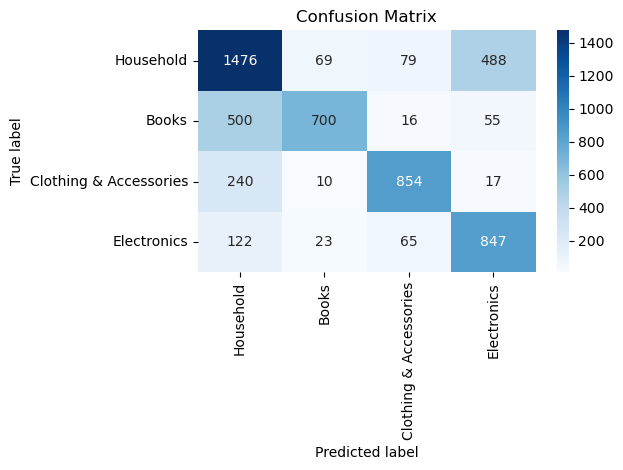

In [270]:
# Ensure consistent label order for rows (true) and columns (predicted)
labels = ['Household', 'Books', 'Clothing & Accessories', 'Electronics']
cm = confusion_matrix(llm_preds['true_label'], llm_preds['predicted_label'], labels=labels)
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# LLM with better defined prompt

## Small amount of data

In [241]:
# Random sampleof 100 test observations
test_sample =test_llm.sample(250, random_state=42).reset_index(drop=True)
#test_sample
# 2. Build a simple list of texts
sample_list= test_sample["Text"].astype(str).tolist()

Classifier with a prompt

In [242]:
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",     # consider a smaller model for speed
    device=-1,                             # CPU (use 0 ONLY if you have a CUDA GPU)
    hypothesis_template= "This amazon product description is about {}." #This amazon product description is about 

)
candidate_labels = [
    'Household',
    'Books',
    'Clothing & Accessories',
    'Electronics'
]

Device set to use cpu


In [243]:
my_dict = {}

for i in tqdm.tqdm(range(0, len(test_sample))):
    
    pred = classifier(
        sample_list[i],
        candidate_labels=candidate_labels,
        multi_label=False
    )
    
    my_dict[i] = {
        "Text":         sample_list[i],
        "true_label":   test_sample.loc[i, "Class"],
        "predicted_label": pred["labels"][0],
        "pred_score":      pred["scores"][0]
    }

100%|██████████| 250/250 [10:23<00:00,  2.49s/it]


In [244]:
sample_preds = pd.DataFrame.from_dict(my_dict, orient="index")

In [245]:
accuracy_score(sample_preds['true_label'], sample_preds['predicted_label'])
# Accuracy jumps up to 77% when using amazon prompt (76.8 when using 250 observations opposed to 100)
# Drops to 73% when using "this product is about:" prompt

0.768

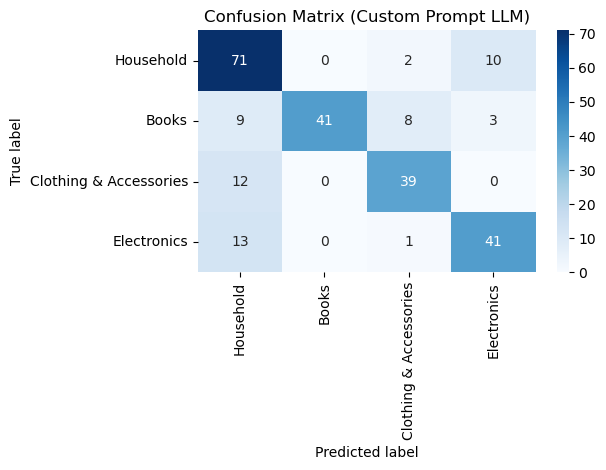

In [272]:
# Ensure consistent label order for rows (true) and columns (predicted)
labels = ['Household', 'Books', 'Clothing & Accessories', 'Electronics']
cm = confusion_matrix(sample_preds['true_label'], sample_preds['predicted_label'], labels=labels)
# Use the same labels for axis tick marks to match cm's row/column order
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Custom Prompt LLM)')
plt.tight_layout()
plt.show()

## Full data

In [39]:
# 1. Build a clean test DataFrame and reset the index so integer indices 0..n-1 are available
test_llm = pd.DataFrame({
    "Text": x_test,
    "Class": y_test
}).reset_index(drop=True)

# Optional sanity checks
print(test_llm.head())

# 2. Build a simple list of texts
test_list = test_llm["Text"].astype(str).tolist()

# 3. Zero-shot classifier (CPU)
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",     # consider a smaller model for speed
    device=-1,                             # CPU (use 0 ONLY if you have a CUDA GPU)
    hypothesis_template= "This amazon product description is about {}."
)

candidate_labels = [
    'Household',
    'Books',
    'Clothing & Accessories',
    'Electronics'
]

# 4. Batched predictions, keeping original + predicted labels
my_dict = {}
batch_size = 64
n = len(test_list)        # use all of them, or set n = 500 for a subset

for start in tqdm.tqdm(range(0, n, batch_size)):
    batch = test_list[start:start + batch_size]

    preds = classifier(
        batch,
        candidate_labels=candidate_labels,
        multi_label=False
    )

    for j, pred in enumerate(preds):
        idx = start + j

        my_dict[idx] = {
            "Text":         test_list[idx],
            "true_label":   test_llm.loc[idx, "Class"],
            "predicted_label": pred["labels"][0],
            "pred_score":      pred["scores"][0]
        }

# 5. Turn dict into DataFrame
llm_preds = pd.DataFrame.from_dict(my_dict, orient="index")
print(llm_preds.head())

# 6. Compute accuracy directly (no merge needed now)
accuracy = accuracy_score(llm_preds["true_label"], llm_preds["predicted_label"])
print("Zero-shot accuracy:", accuracy)


                                                Text                   Class
0  Canon EOS 1500D Digital SLR Camera (Black) wit...             Electronics
1  NIRVA Electric Automatic Yogurt Maker 1L Elect...               Household
2  SHOPTOSHOP Plastic Lint Cum Fuzz Remover for A...               Household
3  Claura Women's Satin Pack of 6pc Night Dress {...  Clothing & Accessories
4  Trishago Head Cable with CR Sensor for Epson P...             Electronics


Device set to use cpu
100%|██████████| 87/87 [3:31:06<00:00, 145.59s/it]  

                                                Text              true_label  \
0  Canon EOS 1500D Digital SLR Camera (Black) wit...             Electronics   
1  NIRVA Electric Automatic Yogurt Maker 1L Elect...               Household   
2  SHOPTOSHOP Plastic Lint Cum Fuzz Remover for A...               Household   
3  Claura Women's Satin Pack of 6pc Night Dress {...  Clothing & Accessories   
4  Trishago Head Cable with CR Sensor for Epson P...             Electronics   

          predicted_label  pred_score  
0             Electronics    0.554502  
1             Electronics    0.537091  
2               Household    0.838209  
3  Clothing & Accessories    0.446813  
4             Electronics    0.694076  
Zero-shot accuracy: 0.7915842474375112


In [40]:
accuracy_score(llm_preds['true_label'], llm_preds['predicted_label'])

0.7915842474375112

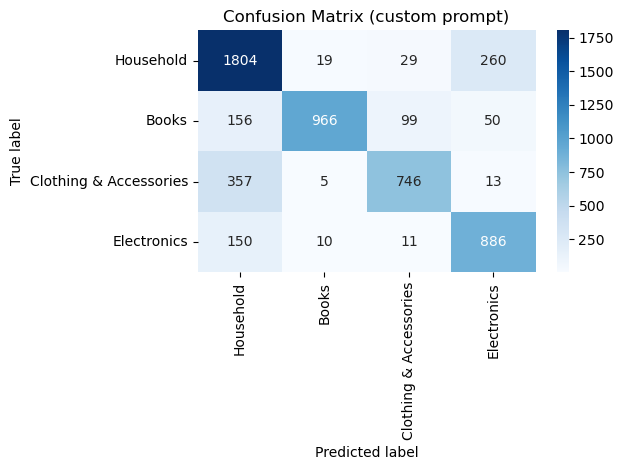

In [70]:
# Ensure consistent label order for rows (true) and columns (predicted)
labels = ['Household', 'Books', 'Clothing & Accessories', 'Electronics']
cm = confusion_matrix(llm_preds['true_label'], llm_preds['predicted_label'], labels=labels)
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (custom prompt)')
plt.tight_layout()
plt.show()